En este archivo vamos a entrenar una red neuronal para predecir el resultado de los partidos de la Champions bsándonos en datos de los último 7 años.

Para empezar primero cargamos las librerias necesarias.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import regularizers
import matplotlib.pyplot as plt
import random

Ahora vamos a empezar el entrenamiento para predecir resultados, pero antes de ello vamos a transformar las columnas string de equipos en numéricas para poder evaluarlas y analizarlas durante el procesamiento de la red neuronal.

In [2]:
# Cargar los datos del ranking UEFA
uefa_ranking = pd.read_csv("data/UEFA_Ranking.csv")

#Saca el número de valores unicos de la columna Club de ranking UEFA
uefa_ranking['Club'].nunique()

570

In [3]:
# Crear un diccionario para mapear nombres de equipos a números únicos
team_mapping = {team: idx + 1 for idx, team in enumerate(uefa_ranking['Club'])}

# Cargar los datos de los partidos de la Champions League 2017
champions_data = pd.read_csv("data/champions-league-2017.csv")

# Crear una columna Home Team Name que sea una copia de la columna Home Team
champions_data['Home Team Name'] = champions_data['Home Team']

# Crear una columna Away Team Name que sea una copia de la columna Away Team
champions_data['Away Team Name'] = champions_data['Away Team']

# Reemplazar nombres de equipos por números en las columnas correspondientes
champions_data['Home Team'] = champions_data['Home Team'].map(team_mapping)
champions_data['Away Team'] = champions_data['Away Team'].map(team_mapping)
champions_data['Winner'] = champions_data['Winner'].map(team_mapping)

Vamos a comprobar que todos los datos están bien.

In [4]:
# Ver las primeras filas de los datos
print(champions_data.head())

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         20         62  1 - 2      62   
1             2            1         11         26  3 - 0      11   
2            13            1          2         53  3 - 0       2   
3            14            1         50          8  0 - 5       8   
4            25            1          9         66  6 - 0       9   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                2            3            Benfica   
1                3                0            3  Manchester United   
2                3                0            3     Bayern München   
3                0                5            5             Celtic   
4                6                0            6            Chelsea   

        Away Team Name  
0          CSKA Moscow  
1             FC Basel  
2           Anderlecht  
3  Paris Saint-Germain  
4           Qarabag FK  


In [5]:
# analizar los datos
print(champions_data.describe())

       Match Number   Home Team   Away Team      Winner  Home Team Goals  \
count    125.000000  125.000000  125.000000  125.000000       125.000000   
mean      63.000000   25.432000   25.464000   17.312000         1.784000   
std       36.228442   28.471076   28.445631   22.202302         1.532361   
min        1.000000    1.000000    1.000000    1.000000         0.000000   
25%       32.000000    6.000000    6.000000    4.000000         1.000000   
50%       63.000000   14.000000   14.000000   10.000000         1.000000   
75%       94.000000   36.000000   36.000000   23.000000         3.000000   
max      125.000000  120.000000  120.000000  120.000000         7.000000   

       Away Team Goals  Match Goals  
count       125.000000   125.000000  
mean          1.424000     3.208000  
std           1.398525     1.622901  
min           0.000000     0.000000  
25%           0.000000     2.000000  
50%           1.000000     3.000000  
75%           2.000000     4.000000  
max        

In [6]:
# ver los datos nulos
print(champions_data.isnull().sum())

Match Number       0
Round Number       0
Home Team          0
Away Team          0
Result             0
Winner             0
Home Team Goals    0
Away Team Goals    0
Match Goals        0
Home Team Name     0
Away Team Name     0
dtype: int64


Ahora vamos a comenzar el proceso de entrenamiento de la red neuronal

In [7]:
'''
# Preprocesamiento de datos
X = champions_data[['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals']].values
y = champions_data['Winner'].values

# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Home Team Goals', 'Away Team Goals']

X_categorical = champions_data[categorical_features].values
X_numeric = champions_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(champions_data['Winner'])
num_classes = len(label_encoder.classes_)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Normalizar los datos
X_train = X_train / np.max(X_train, axis=0)
X_test = X_test / np.max(X_test, axis=0)

# Convertir etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Definir modelo de red neuronal con más complejidad
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

# Compilar modelo con hiperparámetros ajustados
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar modelo
model.fit(X_train, y_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
'''

'\n# Preprocesamiento de datos\nX = champions_data[[\'Home Team\', \'Away Team\', \'Home Team Goals\', \'Away Team Goals\']].values\ny = champions_data[\'Winner\'].values\n\n# Separar características categóricas y numéricas\ncategorical_features = [\'Home Team\', \'Away Team\']\nnumeric_features = [\'Home Team Goals\', \'Away Team Goals\']\n\nX_categorical = champions_data[categorical_features].values\nX_numeric = champions_data[numeric_features].values\n\n# Codificar características categóricas\nX_categorical_encoded = np.zeros_like(X_categorical)\nfor i in range(X_categorical.shape[1]):\n    label_encoder = LabelEncoder()\n    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])\n\n# Normalizar características numéricas\nscaler = StandardScaler()\nX_numeric_scaled = scaler.fit_transform(X_numeric)\n\n# Combinar características categóricas y numéricas\nX_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)\n\n# Codificar etiquetas\nlab

In [8]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

# Crear una columna para representar el resultado del partido
champions_data['Home is Winner'] = champions_data['Home Team Goals'] - champions_data['Away Team Goals']
champions_data['Home is Winner'] = champions_data['Home is Winner'].apply(lambda x: 1 if x > 0 else 0)  # 1 si el equipo local ganó, 0 si no

# Dividir los datos en características (X) y variable objetivo (y)
X = champions_data[['Home Team', 'Away Team']]
y = champions_data['Home is Winner']
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
'''
# Preprocesamiento de datos
X = champions_data[['Home Team', 'Away Team']].values
y = champions_data['Winner'].values

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y = to_categorical(y, num_classes=num_classes)
'''

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir modelo de red neuronal
model = Sequential()
model.add(Dense(128, input_dim=2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilar modelo
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# Entrenar modelo
model.fit(X_train, y_train, epochs=90, batch_size=42, validation_data=(X_test, y_test))

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6375 - loss: 1.0917 - val_accuracy: 0.6400 - val_loss: 0.6477
Epoch 2/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6245 - loss: 1.0063 - val_accuracy: 0.6400 - val_loss: 0.6800
Epoch 3/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6305 - loss: 1.2334 - val_accuracy: 0.6400 - val_loss: 0.7650
Epoch 4/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7051 - loss: 0.8683 - val_accuracy: 0.6400 - val_loss: 0.6780
Epoch 5/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6901 - loss: 0.8785 - val_accuracy: 0.6400 - val_loss: 0.6207
Epoch 6/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6554 - loss: 0.6754 - val_accuracy: 0.6800 - val_loss: 0.6127
Epoch 7/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6732 - loss: 0.7284 - val_accuracy: 0.6000 - val_loss: 0.6859
Epoch 8/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6633 - loss: 0.7916 - val_accuracy: 0.3600 - val_loss: 0.7951

Vemos que el entrenamiento inicial ha ido sin problemas. Vamos a probar a ver que predicciones realizaría nuestra red neuronal en base a los partidos de la Champions utilizada para obtener una medida de precisión real. Para ello primero vamos a medir la precisión de una predicción en general.

In [9]:
# Hacer predicciones en los datos de prueba
predictions = model.predict(X_test)

# Redondear las predicciones a etiquetas binarias (0 o 1)
predicted_labels = (predictions > 0.5).astype(int)

# Calcular la precisión
accuracy = np.mean(predicted_labels.flatten() == y_test)
print("Accuracy on test data:", accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Accuracy on test data: 0.6


Como puede verse con este resultado y la medición general anterior, la precisión del modelo es casi inexistente debido al alto error, por lo que vamos a seguir entrenándolo. Primero vamos a aplicar ingeniería de características para darle al modelo más variables sobre las que extraer información. Algunas de estas nos serán útiles a la hora de predecir el resultado de cada partido:

In [10]:
# Calcular la diferencia de goles entre los equipos
champions_data['Goal Difference'] = champions_data['Home Team Goals'] - champions_data['Away Team Goals']

# Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
champions_data['Home Goals Ratio'] = champions_data['Home Team Goals'] / champions_data['Match Goals']
champions_data['Away Goals Ratio'] = champions_data['Away Team Goals'] / champions_data['Match Goals']

# Fusionar los datos de champions_data con la información de uefa_ranking basado en el nombre del equipo local
champions_data = champions_data.merge(uefa_ranking[['Club', '17/18']], left_on='Home Team Name', right_on='Club', how='left')
champions_data.rename(columns={'17/18': 'Home Team Evaluation'}, inplace=True)
champions_data.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data = champions_data.merge(uefa_ranking[['Club', '17/18']], left_on='Away Team Name', right_on='Club', how='left')
champions_data.rename(columns={'17/18': 'Away Team Evaluation'}, inplace=True)
champions_data.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data['Penalties'] = champions_data['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data['Penalties Winner'] = champions_data.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13
round_number_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    'Round of 16 - Game 1': 7,
    'R16 Game 1': 7,
    'Round of 16 - Game 2': 8,
    'R16 Game 2': 8,
    'Qtr Finals - Game 1': 9,
    'QF Game 1': 9,
    'Qtr Finals - Game 2': 10,
    'QF Game 2': 10,
    'Semi Finals - Game 1': 11,
    'SF Game 1': 11,
    'Semi Finals - Game 2': 12,
    'SF Game 2': 12,
    'Final': 13
}

champions_data['Round Number'] = champions_data['Round Number'].map(round_number_mapping).fillna(champions_data['Round Number'])

# Ver las primeras filas de los datos
print(champions_data.head())


   Match Number  Round Number  Home Team  Away Team Result  Winner  \
0             1             1         15         27  1 - 2      62   
1             2             1         10         19  3 - 0      11   
2            13             1          1         26  3 - 0       2   
3            14             1         25          7  0 - 5       8   
4            25             1          8         28  6 - 0       9   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                2            3            Benfica   
1                3                0            3  Manchester United   
2                3                0            3     Bayern München   
3                0                5            5             Celtic   
4                6                0            6            Chelsea   

        Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0          CSKA Moscow               0               -1          0.333333  

In [11]:
# Ver las estadísticas de los datos
print(champions_data.describe())

       Match Number  Round Number   Home Team   Away Team      Winner  \
count    125.000000    125.000000  125.000000  125.000000  125.000000   
mean      63.000000      4.728000   13.536000   13.568000   17.312000   
std       36.228442      2.823793    9.400192    9.360466   22.202302   
min        1.000000      1.000000    0.000000    0.000000    1.000000   
25%       32.000000      2.000000    5.000000    5.000000    4.000000   
50%       63.000000      4.000000   13.000000   13.000000   10.000000   
75%       94.000000      6.000000   21.000000   21.000000   23.000000   
max      125.000000     13.000000   31.000000   31.000000  120.000000   

       Home Team Goals  Away Team Goals  Match Goals  Home is Winner  \
count       125.000000       125.000000   125.000000       125.00000   
mean          1.784000         1.424000     3.208000         0.44800   
std           1.532361         1.398525     1.622901         0.49929   
min           0.000000         0.000000     0.000000  

In [12]:
# Ver los datos nulos
print(champions_data.isnull().sum())

Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio          7
Away Goals Ratio          7
Home Team Evaluation      0
Away Team Evaluation      0
Penalties                 0
Penalties Winner        118
dtype: int64


In [13]:
# Ver las columnas Home Goals Ratio y Away Goals Ratio donde hay datos nulos
print(champions_data[['Home Goals Ratio', 'Away Goals Ratio']], '\n')
print(champions_data[champions_data['Home Goals Ratio'].isnull()])

     Home Goals Ratio  Away Goals Ratio
0            0.333333          0.666667
1            1.000000          0.000000
2            1.000000          0.000000
3            0.000000          1.000000
4            1.000000          0.000000
..                ...               ...
120          0.714286          0.285714
121          0.333333          0.666667
122          0.500000          0.500000
123          0.666667          0.333333
124          0.750000          0.250000

[125 rows x 2 columns] 

     Match Number  Round Number  Home Team  Away Team Result  Winner  \
5              26             1         13          6  0 - 0       7   
40             29             3         28          6  0 - 0       7   
55             44             4         23          2  0 - 0       3   
78             45             5          5          2  0 - 0       3   
102           103             7          9         10  0 - 0      11   
104           105             8          4         11  0 - 0  

Vemos aquí el problema de partidos donde no hay goles. De momento vamos a dejarlo como está para darle más realismo al entrenamiento de la red neuronal:

In [14]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Preprocesamiento de datos con nuevas características
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']].values
y = champions_data['Home is Winner']'''

# Preprocesamiento de datos con nuevas características
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation']].values
y = champions_data['Home is Winner']

'''
# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']

X_categorical = champions_data[categorical_features].values
X_numeric = champions_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(champions_data['Winner'])
num_classes = len(label_encoder.classes_)
y = to_categorical(y, num_classes=num_classes)'''

print("Número de muestras en X:", X.shape[0])
print("Número de muestras en y:", y.shape[0])

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Normalizar los datos
X_train = X_train / np.max(X_train, axis=0)
X_test = X_test / np.max(X_test, axis=0)


Número de muestras en X: 125
Número de muestras en y: 125


Ahora vamos a ampliar el alcance de nuestra red neuronal:

In [15]:
# Definir modelo de red neuronal con más complejidad
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar modelo con hiperparámetros ajustados
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
model.fit(X_train, y_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.3667 - loss: 0.8114 - val_accuracy: 0.5000 - val_loss: 0.7679
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3750 - loss: 0.7822 - val_accuracy: 0.7500 - val_loss: 0.7359
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4750 - loss: 0.7687 - val_accuracy: 0.6500 - val_loss: 0.7183
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5333 - loss: 0.7584 - val_accuracy: 0.6500 - val_loss: 0.7046
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5250 - loss: 0.7393 - val_accuracy: 0.7500 - val_loss: 0.6897
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5833 - loss: 0.7326 - val_accuracy: 0.8000 - val_loss: 0.6695
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5500 - loss: 0.7320 - val_accuracy: 0.7500 - val_loss: 0.6446
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5750 - loss: 0.7108 - val_accuracy: 0.8500 - val_loss

La precisión ahora está un poco mejor ya que el error es más bajo, pero vamos a ver si podemos seguir mejorando. Para ello, vamos a ir probando diferentes parámetros y configuraciones para ajustar la red neuronal:

In [16]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Definir características y variable objetivo
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation',
                    'Home Goals Ratio', 'Away Goals Ratio',
          'Penalties', 'Penalties Winner']]
y = champions_data['Home is Winner']'''

# Definir características y variable objetivo
X = champions_data[['Round Number', 'Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation']]
y = champions_data['Home is Winner']

'''

# Preprocesamiento de datos con nuevas características
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']].values
y = champions_data['Winner'].values

# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']

X_categorical = champions_data[categorical_features].values
X_numeric = champions_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(champions_data['Winner'])
num_classes = len(label_encoder.classes_)
print("Número de clases:", num_classes)
y = to_categorical(y, num_classes=num_classes)

'''

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

ajustes = []
capas = ["softmax", "relu", "sigmoid", "tanh", "linear"]
optimizador = ["SGD", "RMSprop", "Adam", "AdamW", "Adadelta",
               "Adagrad", "Adamax", "Adafactor", "Nadam", "Ftrl", "Lion"]

num_capas = [1, 2, 3, 4, 5]
num_neuronas = [16, 32, 64, 128, 256, 512, 1024]
learning_rate = [0.1, 0.01, 0.001, 0.0001]

target_accuracy = 0.7
target_loss = 0.3

for _ in range(50):
    # Configuración aleatoria
    configuracion_aleatoria = {
        "capa_activacion": random.choice(capas),
        "optimizador": random.choice(optimizador),
        "num_capas": random.choice(num_capas),
        "num_neuronas": random.choice(num_neuronas),
        "learning_rate": random.choice(learning_rate)
    }

    # Crear el modelo con la configuración aleatoria
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        configuracion_aleatoria["num_neuronas"], input_dim=5, activation=configuracion_aleatoria["capa_activacion"]))
    for _ in range(configuracion_aleatoria["num_capas"] - 1):
        model.add(tf.keras.layers.Dense(
            configuracion_aleatoria["num_neuronas"], activation=configuracion_aleatoria["capa_activacion"]))

    # Última capa ajustada para el problema de clasificación multiclase
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar el modelo con el optimizador y learning rate aleatorio
    optimizer = getattr(tf.keras.optimizers, configuracion_aleatoria["optimizador"])(
        learning_rate=configuracion_aleatoria["learning_rate"])
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=100, batch_size=64)

    # Evaluar modelo
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)


    # Verificar si se alcanzaron las condiciones de término
    if accuracy >= target_accuracy and 0 <= loss <= target_loss:
        break

    # Si no se alcanzaron las condiciones de término, se guarda la configuración y se ordena por precisión en orden ascendente y evitando duplicados
    ajustes.append((configuracion_aleatoria, accuracy, loss))
    print(ajustes)

    # Guardar en un archivo txt
    with open('ajustes.txt', 'w') as f:
        for item in ajustes:
            f.write("%s\n" % str(item))

Epoch 1/100


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5501 - loss: 3.5828  
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5553 - loss: 3.5402 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5449 - loss: 3.5827 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5553 - loss: 3.5451 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5553 - loss: 3.5190 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5501 - loss: 3.5045 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5657 - loss: 3.6034 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5501 - loss: 3.4653 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5709 - loss: 3.6318 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5449 - loss: 3.4760 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5605 - loss: 3.5838 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5449 - loss: 3.4004 


Parece que aumentar la precisión va a ser imposible a menos que añadamos nuevos datos. Vamos pues a continuar añadiéndo datos de entrenamiento. Para ello vamos a prepararlos primero:

In [17]:
champions_data2 = pd.read_csv("data/champions-league-2018.csv")
champions_data3 = pd.read_csv("data/champions-league-2019.csv")
champions_data4 = pd.read_csv("data/champions-league-2020.csv")
champions_data5 = pd.read_csv("data/champions-league-2021.csv")
champions_data6 = pd.read_csv("data/champions-league-2022.csv")

# Reemplazar nombres de equipos por números en las columnas correspondientes
champions = [champions_data2, champions_data3, champions_data4, champions_data5, champions_data6]
years = ['18/19', '19/20', '20/21', '21/22', '22/23']
for data, year in zip(champions, years):

    # Crear una columna Home Team Name que sea una copia de la columna Home Team
    data['Home Team Name'] = data['Home Team']
    # Crear una columna Away Team Name que sea una copia de la columna Away Team
    data['Away Team Name'] = data['Away Team']
    
    data['Home Team'] = data['Home Team'].map(team_mapping)
    data['Away Team'] = data['Away Team'].map(team_mapping)
    data['Winner'] = data['Winner'].map(team_mapping)

    # Crear una columna para representar el resultado del partido
    data['Home is Winner'] = data['Home Team Goals'] - data['Away Team Goals']
    data['Home is Winner'] = data['Home is Winner'].apply(lambda x: 1 if x > 0 else 0)  # 1 si el equipo local ganó, 0 si no

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']


In [18]:
# Ver los datos nulos de cada conjunto de datos
for i, data in enumerate(champions):
    print(f"Data {i + 2} null values:\n{data.isnull().sum()}\n")

Data 2 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Winner      0
Goal Difference     0
Home Goals Ratio    7
Away Goals Ratio    7
dtype: int64

Data 3 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Winner      0
Goal Difference     0
Home Goals Ratio    4
Away Goals Ratio    4
dtype: int64

Data 4 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Wi

Vemos que el csv 2 y 3 tienen datos nulos en partidos. Vamos a visualizarlos:

In [19]:
#Ver las filas Home Team, Away Team y Winner donde hay datos nulos en champions_data2
# Seleccionar las filas donde hay valores nulos en las columnas específicas
null_data = champions_data2[champions_data2[['Home Team', 'Away Team', 'Winner']].isnull().any(axis=1)]

# Mostrar las filas seleccionadas
print(null_data[['Home Team', 'Away Team', 'Winner']])

Empty DataFrame
Columns: [Home Team, Away Team, Winner]
Index: []


Las filas de Home Team donde no se ha podido dar un número al equipo de champions_data2 son la 4, 49 y 86. De Away Team la 24, 44 y 77 y de Winner la 49 que como ya ha salido se descarta. Para solucionar esto vamos a introducir en UEFA_Ranking.csv esos equipos al final y actualizar el mapeo. Para ello buscamos en data/champions-league-2018.csv esas filas, extraemos el nombre del equipo de la columna correspondiente y lo añadimos a UEFA_Ranking con todos los campos 0 excepto el de Position que tendrá el mismo número + 1 que el de la fila anterior última. Después volvemos a mapear:

In [20]:
#Ver la fila 4, 24, 44, 49, 77, 86 de champions-league-2018.csv
league_2018 = pd.read_csv("data/champions-league-2018.csv")
print(league_2018.iloc[[4, 24, 44, 49, 77, 86]])

    Match Number  Round Number            Home Team            Away Team  \
4              5           1.0        Crvena zvezda               Napoli   
24            25           2.0  Paris Saint-Germain        Crvena zvezda   
44            45           3.0            Liverpool        Crvena zvezda   
49            50           4.0        Crvena zvezda            Liverpool   
77            78           5.0               Napoli        Crvena zvezda   
86            87           6.0        Crvena zvezda  Paris Saint-Germain   

   Result               Winner  Home Team Goals  Away Team Goals  Match Goals  
4   0 - 0               Napoli                0                0            0  
24  6 - 1  Paris Saint-Germain                6                1            7  
44  4 - 0            Liverpool                4                0            4  
49  2 - 0        Crvena zvezda                2                0            2  
77  3 - 1               Napoli                3                1   

El problema es el equipo Crvena zvezda. Vamos a añadirlo al mapeo una única vez:

In [21]:
# Agregar una fila para el equipo "Crvena zvezda" al archivo UEFA_Ranking.csv
new_row = {'Club': 'Crvena zvezda'}

if 'Crvena zvezda' not in uefa_ranking['Club'].values:
    uefa_ranking = pd.concat([uefa_ranking, pd.DataFrame([new_row])], ignore_index=True)

    # Guardar el DataFrame actualizado en un nuevo archivo CSV
    uefa_ranking.to_csv("data/UEFA_Ranking.csv", index=False)

In [22]:
uefa_ranking = pd.read_csv("data/UEFA_Ranking.csv")

# Actualizar el mapeo de nombres de equipos a números únicos
team_mapping = {team: idx + 1 for idx, team in enumerate(uefa_ranking['Club'])}

champions_data2 = pd.read_csv("data/champions-league-2018.csv")
champions_data3 = pd.read_csv("data/champions-league-2019.csv")
champions_data4 = pd.read_csv("data/champions-league-2020.csv")
champions_data5 = pd.read_csv("data/champions-league-2021.csv")
champions_data6 = pd.read_csv("data/champions-league-2022.csv")

# Reemplazar nombres de equipos por números en las columnas correspondientes
champions = [champions_data2, champions_data3, champions_data4, champions_data5, champions_data6]
for data in champions:

    # Crear una columna Home Team Name que sea una copia de la columna Home Team
    data['Home Team Name'] = data['Home Team']
    # Crear una columna Away Team Name que sea una copia de la columna Away Team
    data['Away Team Name'] = data['Away Team']
    
    data['Home Team'] = data['Home Team'].map(team_mapping)
    data['Away Team'] = data['Away Team'].map(team_mapping)
    data['Winner'] = data['Winner'].map(team_mapping)

    # Crear una columna para representar el resultado del partido
    data['Home is Winner'] = data['Home Team Goals'] - data['Away Team Goals']
    data['Home is Winner'] = data['Home is Winner'].apply(lambda x: 1 if x > 0 else 0)  # 1 si el equipo local ganó, 0 si no

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']


#Champions 2018

In [23]:

print(champions_data2.head())

# Fusionar los datos de champions_data2 con la información de uefa_ranking basado en el nombre del equipo local
champions_data2 = champions_data2.merge(uefa_ranking[['Club', '18/19']], left_on='Home Team Name', right_on='Club', how='left')
champions_data2.rename(columns={'18/19': 'Home Team Evaluation'}, inplace=True)
champions_data2.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data2 con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data2 = champions_data2.merge(uefa_ranking[['Club', '18/19']], left_on='Away Team Name', right_on='Club', how='left')
champions_data2.rename(columns={'18/19': 'Away Team Evaluation'}, inplace=True)
champions_data2.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data2['Penalties'] = champions_data2['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data2['Penalties Winner'] = champions_data2.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13

round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Qtr Finals - Game 1': 9,
'QF Game 1': 9,
'Qtr Finals - Game 2': 10,
'QF Game 2': 10,
'Semi Finals - Game 1': 11,
'SF Game 1': 11,
'Semi Finals - Game 2': 12,
'SF Game 2': 12,
'Final': 13
}

champions_data2['Round Number'] = champions_data2['Round Number'].map(round_number_mapping).fillna(champions_data2['Round Number'])

#Ver las primeras filas de los datos
print(champions_data2.head())

# Pasar todos los datos a csv
champions_data2.to_csv("data/champions-league-reviewed-2018.csv", index=False)

   Match Number  Round Number  Home Team  Away Team Result  Winner  \
0             1           1.0         18         23  2 - 1      18   
1             2           1.0          3         32  4 - 0       3   
2             3           1.0         37          7  1 - 2       7   
3             4           1.0         31         13  0 - 1      13   
4             5           1.0        570         16  0 - 0      16   

   Home Team Goals  Away Team Goals  Match Goals  Home Team Name  \
0                2                1            3  Internazionale   
1                4                0            4    FC Barcelona   
2                1                2            3       AS Monaco   
3                0                1            1     Club Brugge   
4                0                0            0   Crvena zvezda   

      Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0  Tottenham Hotspur               1                1          0.666667   
1      PSV Eindhoven

In [24]:
# Ver los datos nulos
print(champions_data2.isnull().sum())

Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio          7
Away Goals Ratio          7
Home Team Evaluation      3
Away Team Evaluation      3
Penalties                 0
Penalties Winner        118
dtype: int64


In [25]:
# Ver las filas donde hay valores nulos en Home Team Evaluation y Away Team Evaluation
null_data = champions_data2[champions_data2[['Home Team Evaluation', 'Away Team Evaluation']].isnull().any(axis=1)]

# Mostrar las filas seleccionadas
print(null_data[['Home Team Name', 'Home Team Evaluation', 'Away Team Name', 'Away Team Evaluation']])

         Home Team Name  Home Team Evaluation       Away Team Name  \
4         Crvena zvezda                   NaN               Napoli   
24  Paris Saint-Germain                  19.0        Crvena zvezda   
44            Liverpool                  29.0        Crvena zvezda   
49        Crvena zvezda                   NaN            Liverpool   
77               Napoli                  18.0        Crvena zvezda   
86        Crvena zvezda                   NaN  Paris Saint-Germain   

    Away Team Evaluation  
4                   18.0  
24                   NaN  
44                   NaN  
49                  29.0  
77                   NaN  
86                  19.0  


In [26]:
# Selecciona las filas con valores nulos en 'Home Team Evaluation' o 'Away Team Evaluation'
null_home_evaluations_teams = champions_data2[champions_data2['Home Team Evaluation'].isnull()]
null_away_evaluations_teams = champions_data2[champions_data2['Away Team Evaluation'].isnull()]

# Extrae los nombres de equipo de las filas seleccionadas
null_teams_home = null_home_evaluations_teams['Home Team Name']
null_teams_away = null_away_evaluations_teams['Away Team Name']

# Imprime la lista de nombres de equipo con datos nulos
print(null_teams_home)
print(null_teams_away)


4     Crvena zvezda
49    Crvena zvezda
86    Crvena zvezda
Name: Home Team Name, dtype: object
24    Crvena zvezda
44    Crvena zvezda
77    Crvena zvezda
Name: Away Team Name, dtype: object


Vemos que la fusión de puntuaciones se ha realizado correctamente, ya que los valores coinciden con los correspondientes en el csv UEFA_Ranking.

#Champions 2019

In [27]:
print(champions_data3.head())

# Fusionar los datos de champions_data3 con la información de uefa_ranking basado en el nombre del equipo local
champions_data3 = champions_data3.merge(uefa_ranking[['Club', '19/20']], left_on='Home Team Name', right_on='Club', how='left')
champions_data3.rename(columns={'19/20': 'Home Team Evaluation'}, inplace=True)
champions_data3.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data3 con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data3 = champions_data3.merge(uefa_ranking[['Club', '19/20']], left_on='Away Team Name', right_on='Club', how='left')
champions_data3.rename(columns={'19/20': 'Away Team Evaluation'}, inplace=True)
champions_data3.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data3['Penalties'] = champions_data3['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data3['Penalties Winner'] = champions_data3.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13

round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Quarter Finals': 9,
'Semi Finals': 10,
'Final': 11
}

champions_data3['Round Number'] = champions_data3['Round Number'].map(round_number_mapping).fillna(champions_data3['Round Number'])

#Ver las primeras filas de los datos
print(champions_data3.head())

# Pasar todos los datos a csv
champions_data3.to_csv("data/champions-league-reviewed-2019.csv", index=False)

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         18         44  1 - 1      44   
1             2            1         27         30  1 - 1      30   
2             3            1         16          5  2 - 0      16   
3             4            1         28         78  6 - 2      28   
4             5            1         13          3  0 - 0       3   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                1            2     Internazionale   
1                1                1            2     Olympique Lyon   
2                2                0            2             Napoli   
3                6                2            8        FC Salzburg   
4                0                0            0  Borussia Dortmund   

         Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0          Slavia Praha               0                0              0.50   
1 

#Champions 2020

In [28]:
print(champions_data4.head())

# Fusionar los datos de champions_data4 con la información de uefa_ranking basado en el nombre del equipo local
champions_data4 = champions_data4.merge(uefa_ranking[['Club', '20/21']], left_on='Home Team Name', right_on='Club', how='left')
champions_data4.rename(columns={'20/21': 'Home Team Evaluation'}, inplace=True)
champions_data4.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data4 con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data4 = champions_data4.merge(uefa_ranking[['Club', '20/21']], left_on='Away Team Name', right_on='Club', how='left')
champions_data4.rename(columns={'20/21': 'Away Team Evaluation'}, inplace=True)
champions_data4.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data4['Penalties'] = champions_data4['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data4['Penalties Winner'] = champions_data4.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13

round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Qtr Finals - Game 1': 9,
'QF Game 1': 9,
'Qtr Finals - Game 2': 10,
'QF Game 2': 10,
'Semi Finals - Game 1': 11,
'SF Game 1': 11,
'Semi Finals - Game 2': 12,
'SF Game 2': 12,
'Final': 13
}

champions_data4['Round Number'] = champions_data4['Round Number'].map(round_number_mapping).fillna(champions_data4['Round Number'])

#Ver las primeras filas de los datos
print(champions_data4.head())

# Pasar todos los datos a csv
champions_data4.to_csv("data/champions-league-reviewed-2020.csv", index=False)

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         30         31  1 - 2      31   
1             2            1         33          6  0 - 2       6   
2             3            1         65         70  1 - 1      70   
3             4            1          9         10  0 - 0      10   
4             5            1         34         13  3 - 1      34   

   Home Team Goals  Away Team Goals  Match Goals        Home Team Name  \
0                1                2            3  Zenit St. Petersburg   
1                0                2            2           Dynamo Kyiv   
2                1                1            2         Stade Rennais   
3                0                0            0               Chelsea   
4                3                1            4                 Lazio   

      Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0        Club Brugge               0               -1          0.

#Champions 2021

In [29]:
print(champions_data5.head())

# Fusionar los datos de champions_data5 con la información de uefa_ranking basado en el nombre del equipo local
champions_data5 = champions_data5.merge(uefa_ranking[['Club', '21/22']], left_on='Home Team Name', right_on='Club', how='left')
champions_data5.rename(columns={'21/22': 'Home Team Evaluation'}, inplace=True)
champions_data5.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data5 con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data5 = champions_data5.merge(uefa_ranking[['Club', '21/22']], left_on='Away Team Name', right_on='Club', how='left')
champions_data5.rename(columns={'21/22': 'Away Team Evaluation'}, inplace=True)
champions_data5.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data5['Penalties'] = champions_data5['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data5['Penalties Winner'] = champions_data5.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13

round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Qtr Finals - Game 1': 9,
'QF Game 1': 9,
'Qtr Finals - Game 2': 10,
'QF Game 2': 10,
'Semi Finals - Game 1': 11,
'SF Game 1': 11,
'Semi Finals - Game 2': 12,
'SF Game 2': 12,
'Final': 13
}

champions_data5['Round Number'] = champions_data5['Round Number'].map(round_number_mapping).fillna(champions_data5['Round Number'])

#Ver las primeras filas de los datos
print(champions_data5.head())

# Pasar todos los datos a csv
champions_data5.to_csv("data/champions-league-reviewed-2021.csv", index=False)

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             2            1         55         11  2 - 1      55   
1             3            1         10         28  1 - 1      28   
2             1            1         19        504  2 - 2     504   
3             4            1         33         20  0 - 0      20   
4             5            1          3          2  0 - 3       2   

   Home Team Goals  Away Team Goals  Match Goals Home Team Name  \
0                2                1            3     Young Boys   
1                1                1            2        Sevilla   
2                2                2            4     Villarreal   
3                0                0            0    Dynamo Kyiv   
4                0                3            3   FC Barcelona   

      Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0  Manchester United               1                1          0.666667   
1        FC Salzburg            

#Champions 2022

In [30]:
print(champions_data6.head())

# Fusionar los datos de champions_data6 con la información de uefa_ranking basado en el nombre del equipo local
champions_data6 = champions_data6.merge(uefa_ranking[['Club', '22/23']], left_on='Home Team Name', right_on='Club', how='left')
champions_data6.rename(columns={'22/23': 'Home Team Evaluation'}, inplace=True)
champions_data6.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data6 con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data6 = champions_data6.merge(uefa_ranking[['Club', '22/23']], left_on='Away Team Name', right_on='Club', how='left')
champions_data6.rename(columns={'22/23': 'Away Team Evaluation'}, inplace=True)
champions_data6.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data6['Penalties'] = champions_data6['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data6['Penalties Winner'] = champions_data6.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13

round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Qtr Finals - Game 1': 9,
'QF Game 1': 9,
'Qtr Finals - Game 2': 10,
'QF Game 2': 10,
'Semi Finals - Game 1': 11,
'SF Game 1': 11,
'Semi Finals - Game 2': 12,
'SF Game 2': 12,
'Final': 13
}

champions_data6['Round Number'] = champions_data6['Round Number'].map(round_number_mapping).fillna(champions_data6['Round Number'])

#Ver las primeras filas de los datos
print(champions_data6.head())

# Pasar todos los datos a csv
champions_data6.to_csv("data/champions-league-reviewed-2022.csv", index=False)

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         43          9  1 - 0      43   
1             2            1         13         38  3 - 0      13   
2             3            1         28         25  1 - 1      25   
3             4            1         50          1  0 - 3       1   
4             5            1         24         21  1 - 4      21   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                0            1      Dinamo Zagreb   
1                3                0            3  Borussia Dortmund   
2                1                1            2        FC Salzburg   
3                0                3            3             Celtic   
4                1                4            5         RB Leipzig   

     Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0           Chelsea               1                1               1.0   
1      FC 

In [31]:
champions = [champions_data, champions_data2, champions_data3, champions_data4, champions_data5, champions_data6]

# Ver los datos nulos de cada conjunto de datos
for i, data in enumerate(champions):
    print(f"Data {i + 1} null values:\n{data.isnull().sum()}\n")

Data 1 null values:
Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio          7
Away Goals Ratio          7
Home Team Evaluation      0
Away Team Evaluation      0
Penalties                 0
Penalties Winner        118
dtype: int64

Data 2 null values:
Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio          7
Away Goals Ratio      

Vemos que ya no hay valores nulos donde no debe haberlos, así que proseguimos con la unión de los datos:

In [32]:
# Concatenar todos los datos verticalmente
combined_data = pd.concat([champions_data, champions_data2, champions_data3, champions_data4, champions_data5, champions_data6], axis=0, ignore_index=True)

Vamos a analizar el resultado de la unión:

In [33]:
# Ver las filas union de los datos
print(combined_data.head())

   Match Number  Round Number  Home Team  Away Team Result  Winner  \
0             1           1.0         15         27  1 - 2      62   
1             2           1.0         10         19  3 - 0      11   
2            13           1.0          1         26  3 - 0       2   
3            14           1.0         25          7  0 - 5       8   
4            25           1.0          8         28  6 - 0       9   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                2            3            Benfica   
1                3                0            3  Manchester United   
2                3                0            3     Bayern München   
3                0                5            5             Celtic   
4                6                0            6            Chelsea   

        Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0          CSKA Moscow               0               -1          0.333333  

In [34]:
# Ver la forma de los datos combinados
print(combined_data.shape)

(744, 19)


In [35]:
# Ver los datos
print(combined_data.describe())

       Match Number  Round Number   Home Team   Away Team      Winner  \
count    744.000000    744.000000  744.000000  744.000000  744.000000   
mean      62.538978      4.674731   34.951613   34.229839   25.051075   
std       35.883295      2.760343   81.068207   79.237447   65.773277   
min        1.000000      1.000000    0.000000    0.000000    1.000000   
25%       31.750000      2.000000    7.000000    7.000000    5.000000   
50%       62.500000      4.000000   17.000000   17.000000   11.000000   
75%       93.250000      6.000000   30.000000   30.000000   23.000000   
max      125.000000     13.000000  570.000000  570.000000  570.000000   

       Home Team Goals  Away Team Goals  Match Goals  Home is Winner  \
count       744.000000       744.000000   744.000000      744.000000   
mean          1.649194         1.403226     3.052419        0.446237   
std           1.433797         1.385870     1.723465        0.497435   
min           0.000000         0.000000     0.000000  

In [36]:
# Ver los datos nulos
print(combined_data.isnull().sum())

Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio         40
Away Goals Ratio         40
Home Team Evaluation     18
Away Team Evaluation     17
Penalties                 0
Penalties Winner        704
dtype: int64


In [37]:
#mostrar las filas con datos nulos
print(combined_data[combined_data.isnull().any(axis=1)])

     Match Number  Round Number  Home Team  Away Team Result  Winner  \
0               1           1.0         15         27  1 - 2      62   
1               2           1.0         10         19  3 - 0      11   
2              13           1.0          1         26  3 - 0       2   
3              14           1.0         25          7  0 - 5       8   
4              25           1.0          8         28  6 - 0       9   
..            ...           ...        ...        ...    ...     ...   
739           121          11.0          1          4  1 - 1       4   
740           122          11.0         25         18  0 - 2      18   
741           123          12.0         18         25  1 - 0      18   
742           124          12.0          4          1  4 - 0       4   
743           125          13.0          4         18  1 - 0       4   

     Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                  1                2            3            

In [38]:
# Sacar el numero de datos totales de las columnas ['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']
print(combined_data[['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']].count())

Home Team           744
Away Team           744
Home Team Goals     744
Away Team Goals     744
Goal Difference     744
Home Goals Ratio    704
Away Goals Ratio    704
Winner              744
dtype: int64


In [39]:
# Sacar el numero de datos únicos de las columnas ['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']
print(combined_data[['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']].nunique())

Home Team           68
Away Team           68
Home Team Goals      8
Away Team Goals      9
Goal Difference     15
Home Goals Ratio    23
Away Goals Ratio    23
Winner              65
dtype: int64


Tras varias pruebas nos hemos dado cuenta de que no somos capaces de eliminar o mitigar el sobreajuste dado de ampliar la muestra, por lo que vamos a probar a entrenar nuestra red con los datos de uno de los csv:

In [40]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Definir características y variable objetivo
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation',
                    'Home Goals Ratio', 'Away Goals Ratio',
          'Penalties', 'Penalties Winner']]
y = champions_data['Home is Winner']'''

# Definir características y variable objetivo
X = champions_data[['Round Number', 'Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation'
                    ]]
y = champions_data['Home is Winner']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

ajustes = []
capas = ["softmax", "relu", "sigmoid", "tanh", "linear"]
optimizador = ["SGD", "RMSprop", "Adam", "AdamW", "Adadelta",
               "Adagrad", "Adamax", "Adafactor", "Nadam", "Ftrl", "Lion"]

num_capas = [1, 2, 3, 4, 5]
num_neuronas = [16, 32, 64, 128, 256, 512, 1024]
learning_rate = [0.1, 0.01, 0.001, 0.0001]

target_accuracy = 0.7
target_loss = 0.3

for _ in range(50):
    # Configuración aleatoria
    configuracion_aleatoria = {
        "capa_activacion": random.choice(capas),
        "optimizador": random.choice(optimizador),
        "num_capas": random.choice(num_capas),
        "num_neuronas": random.choice(num_neuronas),
        "learning_rate": random.choice(learning_rate)
    }

    # Crear el modelo con la configuración aleatoria
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        configuracion_aleatoria["num_neuronas"], input_dim=5, activation=configuracion_aleatoria["capa_activacion"]))
    for _ in range(configuracion_aleatoria["num_capas"] - 1):
        model.add(tf.keras.layers.Dense(
            configuracion_aleatoria["num_neuronas"], activation=configuracion_aleatoria["capa_activacion"]))
        model.add(tf.keras.layers.Dropout(0.5))

    # Última capa ajustada para el problema de clasificación multiclase
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar el modelo con el optimizador y learning rate aleatorio
    optimizer = getattr(tf.keras.optimizers, configuracion_aleatoria["optimizador"])(
        learning_rate=configuracion_aleatoria["learning_rate"])
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=90, batch_size=64)

    # Evaluar modelo
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)


    # Verificar si se alcanzaron las condiciones de término
    if accuracy >= target_accuracy and 0 <= loss <= target_loss:
        break

    # Si no se alcanzaron las condiciones de término, se guarda la configuración y se ordena por precisión en orden ascendente y evitando duplicados
    ajustes.append((configuracion_aleatoria, accuracy, loss))
    print(ajustes)

    # Guardar en un archivo txt
    with open('ajustes_ampliado.txt', 'w') as f:
        for item in ajustes:
            f.write("%s\n" % str(item))

c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/90


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6172 - loss: 0.7419
Epoch 2/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6941 - loss: 0.7005 
Epoch 3/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5345 - loss: 0.7715 
Epoch 4/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5786 - loss: 0.7466 
Epoch 5/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5038 - loss: 0.7635 
Epoch 6/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5679 - loss: 0.7060 
Epoch 7/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4962 - loss: 0.8422 
Epoch 8/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4962 - loss: 0.8238 
Epoch 9/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4499 - loss: 0.8638 
Epoch 10/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5296 - loss: 0.7700 
Epoch 11/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4447 - loss: 0.8077 
Epoch 12/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6506 - loss: 0.7960 
Epoch 13/90


Usando el modelo que mejores resultados nos ha proporcionado de los anteriores vamos a ver una representación gráfica de la precisión y pérdida incurrida en el último ciclo exitoso. En este caso los dos modelos que mejores resultados nos han proporcionado son:

({'capa_activacion': 'linear', 'optimizador': 'Adam', 'num_capas': 1, 'num_neuronas': 16, 'learning_rate': 0.001}, 0.7368420958518982, 0.3422488570213318)

({'capa_activacion': 'tanh', 'optimizador': 'Nadam', 'num_capas': 3, 'num_neuronas': 32, 'learning_rate': 0.001}, 0.7105262875556946, 0.40350401401519775)

In [50]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Definir características y variable objetivo
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation',
                    'Home Goals Ratio', 'Away Goals Ratio',
          'Penalties', 'Penalties Winner']]
y = champions_data['Home is Winner']'''

# Definir características y variable objetivo
X = champions_data[['Round Number', 'Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation'
                    ]]
y = champions_data['Home is Winner']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

capas = ["linear"]
optimizador = ["Adam"]

num_capas = [1]
num_neuronas = [16]
learning_rate = [0.001]

# Configuración aleatoria
configuracion_aleatoria = {
    "capa_activacion": random.choice(capas),
    "optimizador": random.choice(optimizador),
    "num_capas": random.choice(num_capas),
    "num_neuronas": random.choice(num_neuronas),
    "learning_rate": random.choice(learning_rate)
}

# Crear el modelo con la configuración aleatoria
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(
    configuracion_aleatoria["num_neuronas"], input_dim=5, activation=configuracion_aleatoria["capa_activacion"]))
for _ in range(configuracion_aleatoria["num_capas"] - 1):
    model.add(tf.keras.layers.Dense(
        configuracion_aleatoria["num_neuronas"], activation=configuracion_aleatoria["capa_activacion"]))
    model.add(tf.keras.layers.Dropout(0.5))

# Última capa ajustada para el problema de clasificación multiclase
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compilar el modelo con el optimizador y learning rate aleatorio
optimizer = getattr(tf.keras.optimizers, configuracion_aleatoria["optimizador"])(
    learning_rate=configuracion_aleatoria["learning_rate"])
model.compile(optimizer=optimizer,
                loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=90, batch_size=64, validation_data=(X_test, y_test))

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Guardar el modelo
model.save("model.h5")

Epoch 1/90


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.4291 - loss: 7.6372 - val_accuracy: 0.5000 - val_loss: 7.8666
Epoch 2/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4576 - loss: 7.3755 - val_accuracy: 0.5000 - val_loss: 7.4730
Epoch 3/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4680 - loss: 7.0589 - val_accuracy: 0.5000 - val_loss: 7.0843
Epoch 4/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4499 - loss: 6.6440 - val_accuracy: 0.4737 - val_loss: 6.7061
Epoch 5/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4576 - loss: 6.4810 - val_accuracy: 0.5000 - val_loss: 6.3416
Epoch 6/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4395 - loss: 5.9702 - val_accuracy: 0.5000 - val_loss: 5.9939
Epoch 7/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4318 - loss: 5.8197 - val_accuracy: 0.5263 - val_loss: 5.6671
Epoch 8/90
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4370 - loss: 5.3941 - val_accuracy: 0.5000 - val_loss: 5.3658
Epoch 9/90

Test Loss: 0.27447256445884705
Test Accuracy: 0.8421052694320679


En este caso la precisión incluso mejora. Veamos la gráfica correspondiente:

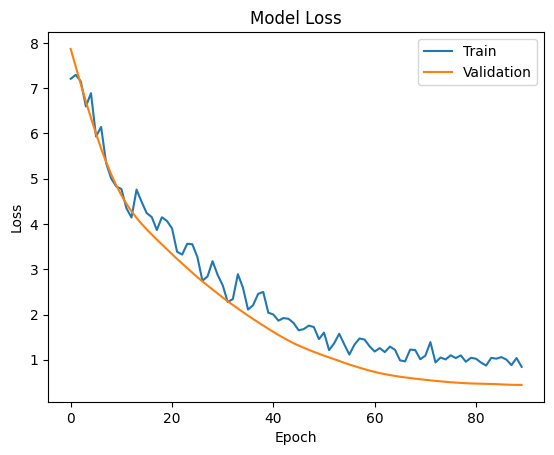

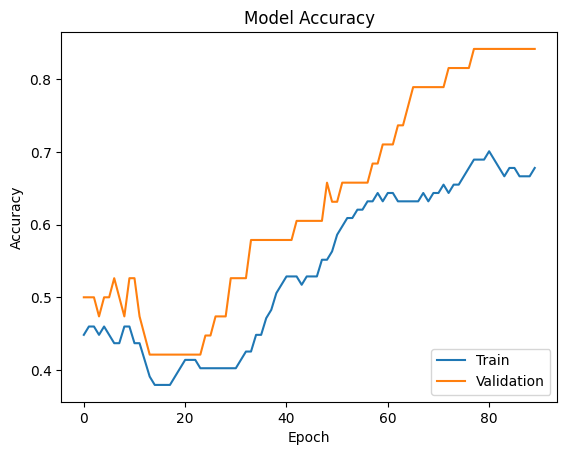

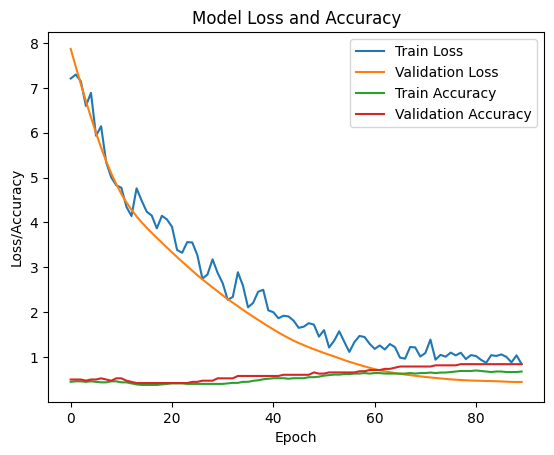

In [51]:
# Pérdida y precisión
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Pérdida y precisión en la misma gráfica
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()


Este modelo da muy buenos resultados. Veamos el otro posible:

In [64]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Definir características y variable objetivo
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation',
                    'Home Goals Ratio', 'Away Goals Ratio',
          'Penalties', 'Penalties Winner']]
y = champions_data['Home is Winner']'''

# Definir características y variable objetivo
X = champions_data[['Round Number', 'Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation'
                    ]]
y = champions_data['Home is Winner']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

capas = ["tanh"]
optimizador = ["Nadam"]

num_capas = [3]
num_neuronas = [32]
learning_rate = [0.001]

# Configuración aleatoria
configuracion_aleatoria = {
    "capa_activacion": random.choice(capas),
    "optimizador": random.choice(optimizador),
    "num_capas": random.choice(num_capas),
    "num_neuronas": random.choice(num_neuronas),
    "learning_rate": random.choice(learning_rate)
}

# Crear el modelo con la configuración aleatoria
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(
    configuracion_aleatoria["num_neuronas"], input_dim=5, activation=configuracion_aleatoria["capa_activacion"]))
for _ in range(configuracion_aleatoria["num_capas"] - 1):
    model.add(tf.keras.layers.Dense(
        configuracion_aleatoria["num_neuronas"], activation=configuracion_aleatoria["capa_activacion"]))
    model.add(tf.keras.layers.Dropout(0.5))

# Última capa ajustada para el problema de clasificación multiclase
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compilar el modelo con el optimizador y learning rate aleatorio
optimizer = getattr(tf.keras.optimizers, configuracion_aleatoria["optimizador"])(
    learning_rate=configuracion_aleatoria["learning_rate"])
model.compile(optimizer=optimizer,
                loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=58, validation_data=(X_test, y_test))

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Guardar el modelo
model.save("model2.h5")

Epoch 1/100


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.4778 - loss: 0.8027 - val_accuracy: 0.5312 - val_loss: 0.7056
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5193 - loss: 0.7431 - val_accuracy: 0.5625 - val_loss: 0.6874
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4892 - loss: 0.7553 - val_accuracy: 0.6875 - val_loss: 0.6636
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5452 - loss: 0.7621 - val_accuracy: 0.7812 - val_loss: 0.6395
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5352 - loss: 0.7083 - val_accuracy: 0.7500 - val_loss: 0.6211
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6098 - loss: 0.6466 - val_accuracy: 0.6875 - val_loss: 0.6017
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5193 - loss: 0.7311 - val_accuracy: 0.6875 - val_loss: 0.5847
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6284 - loss: 0.6785 - val_accuracy: 0.6875 - val_loss: 0.5730
Ep

Test Loss: 0.38604217767715454
Test Accuracy: 0.78125


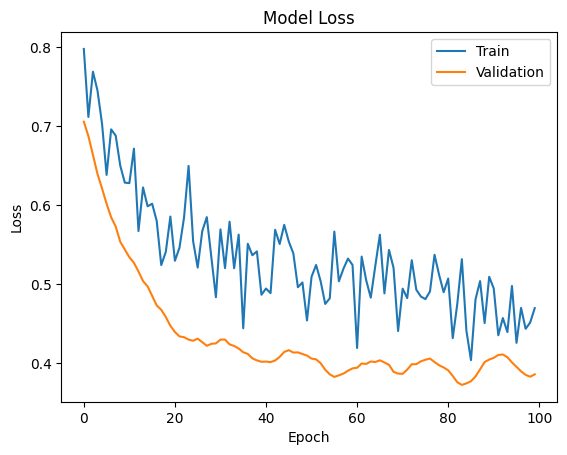

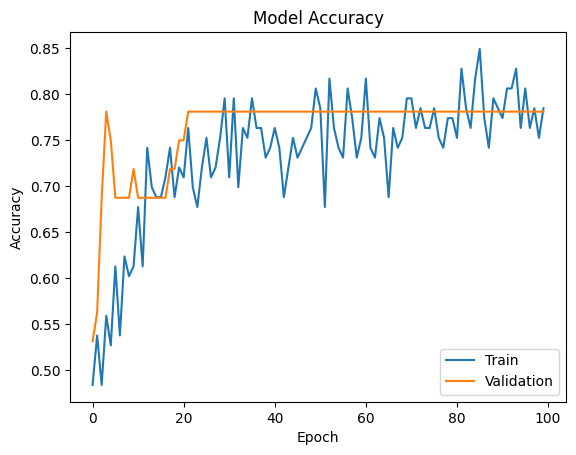

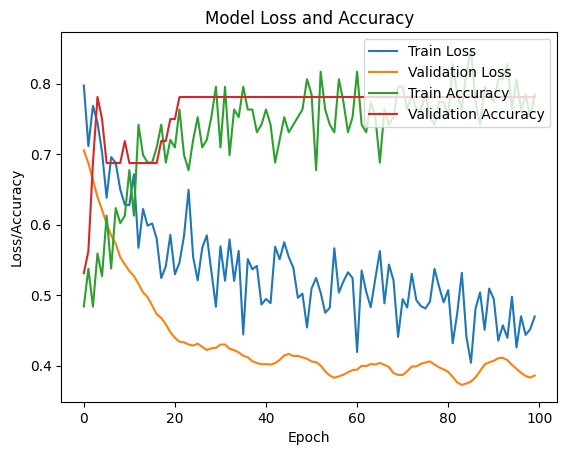

In [65]:
# Pérdida y precisión
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Pérdida y precisión en la misma gráfica
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()

Es menos preciso que el primero, pero más complejo, por lo que posiblemente más real. Ahora usemos estos dos modelos para hacer una prueba de un partido real. Primero veamos sus estadísticas:

In [54]:
# Cargar el modelo
model = tf.keras.models.load_model("model.h5")

# Hacer predicciones sobre el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones a clases (0 o 1)
predicted_classes = (predictions > 0.5).astype("int32")

# Calcular métricas de evaluación del modelo
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)
class_report = classification_report(y_test, predicted_classes)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Accuracy: 0.875
Confusion Matrix:
[[20  3]
 [ 1  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        23
           1       0.73      0.89      0.80         9

    accuracy                           0.88        32
   macro avg       0.84      0.88      0.85        32
weighted avg       0.89      0.88      0.88        32



Ahora hagamos una predicción:

In [55]:
# Cargar el modelo entrenado
model = tf.keras.models.load_model("model.h5")

# Definir la información del partido
round_number = 1  # Ronda correspondiente
real_madrid_evaluation = 363.0  # Evaluación del Real Madrid
fc_barcelona_evaluation = 264.0  # Evaluación del FC Barcelona

# Nombres de los equipos
home_team_name = "Real Madrid"
away_team_name = "FC Barcelona"

# Mapear los nombres de los equipos a los números únicos usando team_mapping
home_team_name = team_mapping[home_team_name]
away_team_name = team_mapping[away_team_name]

print(home_team_name, ',', away_team_name)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, home_team_name, away_team_name, real_madrid_evaluation, fc_barcelona_evaluation]])

# Hacer la predicción utilizando el modelo cargado
prediction = model.predict(prediction_features)

# Imprimir la predicción
print("Predicción de que gane el equipo local (Real Madrid):")
print(prediction)


1 , 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicción de que gane el equipo local (Real Madrid):
[[1.]]


Tras hacer varias pruebas llego a la conclusión de que este modelo no acaba de predecir con la misma exactitud que el segundo. Puede deberse a que su estructura es muy simple, lo que le ha otorgado esa falsa sensación de precisión. Probemos ahora con el segundo modelo:

In [66]:
# Cargar el modelo
model = tf.keras.models.load_model("model2.h5")

# Hacer predicciones sobre el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones a clases (0 o 1)
predicted_classes = (predictions > 0.5).astype("int32")

# Calcular métricas de evaluación del modelo
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)
class_report = classification_report(y_test, predicted_classes)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Accuracy: 0.78125
Confusion Matrix:
[[17  6]
 [ 1  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83        23
           1       0.57      0.89      0.70         9

    accuracy                           0.78        32
   macro avg       0.76      0.81      0.76        32
weighted avg       0.84      0.78      0.79        32



In [67]:
# Cargar el modelo entrenado
model = tf.keras.models.load_model("model2.h5")

# Definir la información del partido
round_number = 1  # Ronda correspondiente
real_madrid_evaluation = 363.0  # Evaluación del Real Madrid
fc_barcelona_evaluation = 264.0  # Evaluación del FC Barcelona

# Nombres de los equipos
home_team_name = "Real Madrid"
away_team_name = "FC Barcelona"

# Mapear los nombres de los equipos a los números únicos usando team_mapping
home_team_name = team_mapping[home_team_name]
away_team_name = team_mapping[away_team_name]

print(home_team_name, ',', away_team_name)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, home_team_name, away_team_name, real_madrid_evaluation, fc_barcelona_evaluation]])

# Hacer la predicción utilizando el modelo cargado
prediction = model.predict(prediction_features)

# Imprimir la predicción
print("Predicción de que gane el equipo local (Real Madrid):")
print(prediction)

1 , 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicción de que gane el equipo local (Real Madrid):
[[0.8161984]]


Este está más preparado. Probemos ahora a predecir los partidos de la Champions de este año!

In [69]:
'''# Primero hay que limpiar los datos
champions2023 = pd.read_csv("data/champions-league-2023-UTC.csv")

# Eliminar las columnas Date, Location y Group
champions2023.drop(columns=['Date', 'Location', 'Group'], inplace=True)

# Cambiamos Round Number por numeros siguiendo el diccionario
round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Qtr Finals - Game 1': 9,
'QF Game 1': 9,
'Qtr Finals - Game 2': 10,
'QF Game 2': 10,
'Semi Finals - Game 1': 11,
'SF Game 1': 11,
'Semi Finals - Game 2': 12,
'SF Game 2': 12,
'Final': 13
}

champions2023['Round Number'] = champions2023['Round Number'].map(round_number_mapping).fillna(champions2023['Round Number'])

#Guardar los datos
champions2023.to_csv("data/champions-league-2023.csv", index=False)'''

In [70]:
'''#Abrir champions2023, mapear los nombres y meter columnas Home Team Name y Away Team Name
champions2023 = pd.read_csv("data/champions-league-2023.csv")

# Crear una columna Home Team Name que sea una copia de la columna Home Team
champions2023['Home Team Name'] = champions2023['Home Team']

# Crear una columna Away Team Name que sea una copia de la columna Away Team
champions2023['Away Team Name'] = champions2023['Away Team']

# Reemplazar nombres de equipos por números en las columnas correspondientes
champions2023['Home Team'] = champions2023['Home Team'].map(team_mapping)
champions2023['Away Team'] = champions2023['Away Team'].map(team_mapping)

# Ver las primeras filas de los datos
print(champions2023.head())
'''

   Match Number  Round Number  Home Team  Away Team Result Home Team Name  \
0             1             1        NaN        NaN  0 - 0          Milan   
1             2             1       55.0        NaN  1 - 3     Young Boys   
2             3             1       36.0       50.0  2 - 0      Feyenoord   
3             4             1       34.0        NaN  1 - 1          Lazio   
4             5             1        NaN        NaN  2 - 0          Paris   

       Away Team Name  
0           Newcastle  
1             Leipzig  
2              Celtic  
3  Atlético de Madrid  
4            Dortmund  


Ya preparado el csv hemos hecho unos arreglos manuales para actualizarlo. Ahora vamos a predecir al ganador de la Champions 2023/24!!

Cuartos, primer partido: Atlético Madrid vs Borussia Dortmund

In [68]:
equipo1 = "Atlético Madrid"
equipo2 = "Borussia Dortmund"

# Encontrar el índice de la columna 'Total Points'
indice_total_points = uefa_ranking.columns.get_loc('Total Points')

# Obtener el valor de 'Total Points' correspondiente al equipo
total_points_equipo1 = uefa_ranking.loc[uefa_ranking['Club'] == equipo1, 'Total Points'].values[0]
total_points_equipo2 = uefa_ranking.loc[uefa_ranking['Club'] == equipo2, 'Total Points'].values[0]

print("El número de la columna 'Total Points' correspondiente al equipo", equipo1, "es:", total_points_equipo1)
print("El número de la columna 'Total Points' correspondiente al equipo", equipo2, "es:", total_points_equipo2)


El número de la columna 'Total Points' correspondiente al equipo Atlético Madrid es: 218.0
El número de la columna 'Total Points' correspondiente al equipo Borussia Dortmund es: 179.0


In [69]:
# Definir la información del partido
round_number = 9  # Ronda correspondiente

print(equipo1, ',', equipo2)

model = tf.keras.models.load_model("model2.h5")

# Mapear los nombres de los equipos a los números únicos usando team_mapping
equipo1_map = team_mapping[equipo1]
equipo2_map = team_mapping[equipo2]

print(equipo1, ',', equipo2)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo1_map, equipo2_map, total_points_equipo1, total_points_equipo2]])

# Hacer la predicción utilizando el modelo cargado
prediction1 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo1} en la ronda 9 es:")
print(prediction1)

Atlético Madrid , Borussia Dortmund
Atlético Madrid , Borussia Dortmund
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Probabilidad de que gane Atlético Madrid en la ronda 9 es:
[[0.7258141]]


In [70]:
# Definir la información del partido
round_number = 10  # Ronda correspondiente

print(equipo2, ',', equipo1)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo2_map, equipo1_map, total_points_equipo2, total_points_equipo1]])

# Hacer la predicción utilizando el modelo cargado
prediction2 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo2} en la ronda 10 es:")
print(prediction2)

Borussia Dortmund , Atlético Madrid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Probabilidad de que gane Borussia Dortmund en la ronda 10 es:
[[0.22052413]]


In [71]:
# Calcular el porcentaje de predicción de cada equipo
percentage_prediction1 = prediction1[0][0]
percentage_prediction2 = prediction2[0][0]

# Calcular la probabilidad acumulada de cada equipo
cumulative_probability1 = (percentage_prediction1 + (1 - percentage_prediction2))/2
cumulative_probability2 = (percentage_prediction2 + (1 - percentage_prediction1))/2

# Determinar el ganador
if cumulative_probability1 > cumulative_probability2:
    winner = equipo1
    probability_winner = cumulative_probability1
else:
    winner = equipo2
    probability_winner = cumulative_probability2

# Imprimir el ganador y su probabilidad de victoria
print(f"El ganador del partido entre {equipo1} y {equipo2} es: {winner}")
print(f"Probabilidad de victoria para {winner}: {probability_winner}%")


El ganador del partido entre Atlético Madrid y Borussia Dortmund es: Atlético Madrid
Probabilidad de victoria para Atlético Madrid: 0.7526449859142303%


Cuartos, segundo partido: Paris Saint-Germain vs FC Barcelona

In [72]:
equipo1 = "Paris Saint-Germain"
equipo2 = "FC Barcelona"

# Encontrar el índice de la columna 'Total Points'
indice_total_points = uefa_ranking.columns.get_loc('Total Points')

# Obtener el valor de 'Total Points' correspondiente al equipo
total_points_equipo1 = uefa_ranking.loc[uefa_ranking['Club'] == equipo1, 'Total Points'].values[0]
total_points_equipo2 = uefa_ranking.loc[uefa_ranking['Club'] == equipo2, 'Total Points'].values[0]

print("El número de la columna 'Total Points' correspondiente al equipo", equipo1, "es:", total_points_equipo1)
print("El número de la columna 'Total Points' correspondiente al equipo", equipo2, "es:", total_points_equipo2)


El número de la columna 'Total Points' correspondiente al equipo Paris Saint-Germain es: 215.0
El número de la columna 'Total Points' correspondiente al equipo FC Barcelona es: 264.0


In [73]:
# Definir la información del partido
round_number = 9  # Ronda correspondiente

print(equipo1, ',', equipo2)

# Mapear los nombres de los equipos a los números únicos usando team_mapping
equipo1_map = team_mapping[equipo1]
equipo2_map = team_mapping[equipo2]

print(equipo1, ',', equipo2)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo1_map, equipo2_map, total_points_equipo1, total_points_equipo2]])

# Hacer la predicción utilizando el modelo cargado
prediction1 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo1} en la ronda 9 es:")
print(prediction1)

Paris Saint-Germain , FC Barcelona
Paris Saint-Germain , FC Barcelona
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Probabilidad de que gane Paris Saint-Germain en la ronda 9 es:
[[0.24148573]]


In [74]:
# Definir la información del partido
round_number = 10  # Ronda correspondiente

print(equipo2, ',', equipo1)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo2_map, equipo1_map, total_points_equipo2, total_points_equipo1]])

# Hacer la predicción utilizando el modelo cargado
prediction2 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo2} en la ronda 10 es:")
print(prediction2)

FC Barcelona , Paris Saint-Germain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Probabilidad de que gane FC Barcelona en la ronda 10 es:
[[0.6759523]]


In [75]:
# Calcular el porcentaje de predicción de cada equipo
percentage_prediction1 = prediction1[0][0]
percentage_prediction2 = prediction2[0][0]

# Calcular la probabilidad acumulada de cada equipo
cumulative_probability1 = (percentage_prediction1 + (1 - percentage_prediction2))/2
cumulative_probability2 = (percentage_prediction2 + (1 - percentage_prediction1))/2

# Determinar el ganador
if cumulative_probability1 > cumulative_probability2:
    winner = equipo1
    probability_winner = cumulative_probability1
else:
    winner = equipo2
    probability_winner = cumulative_probability2

# Imprimir el ganador y su probabilidad de victoria
print(f"El ganador del partido entre {equipo1} y {equipo2} es: {winner}")
print(f"Probabilidad de victoria para {winner}: {probability_winner}%")


El ganador del partido entre Paris Saint-Germain y FC Barcelona es: FC Barcelona
Probabilidad de victoria para FC Barcelona: 0.7172332927584648%


Cuartos, tercer partido: Arsenal vs Bayern München

In [76]:
equipo1 = "Arsenal"
equipo2 = "Bayern München"

# Encontrar el índice de la columna 'Total Points'
indice_total_points = uefa_ranking.columns.get_loc('Total Points')

# Obtener el valor de 'Total Points' correspondiente al equipo
total_points_equipo1 = uefa_ranking.loc[uefa_ranking['Club'] == equipo1, 'Total Points'].values[0]
total_points_equipo2 = uefa_ranking.loc[uefa_ranking['Club'] == equipo2, 'Total Points'].values[0]

print("El número de la columna 'Total Points' correspondiente al equipo", equipo1, "es:", total_points_equipo1)
print("El número de la columna 'Total Points' correspondiente al equipo", equipo2, "es:", total_points_equipo2)


El número de la columna 'Total Points' correspondiente al equipo Arsenal es: 171.0
El número de la columna 'Total Points' correspondiente al equipo Bayern München es: 307.0


In [77]:
# Definir la información del partido
round_number = 9  # Ronda correspondiente

print(equipo1, ',', equipo2)

# Mapear los nombres de los equipos a los números únicos usando team_mapping
equipo1_map = team_mapping[equipo1]
equipo2_map = team_mapping[equipo2]

print(equipo1, ',', equipo2)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo1_map, equipo2_map, total_points_equipo1, total_points_equipo2]])

# Hacer la predicción utilizando el modelo cargado
prediction1 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo1} en la ronda 9 es:")
print(prediction1)

Arsenal , Bayern München
Arsenal , Bayern München
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Probabilidad de que gane Arsenal en la ronda 9 es:
[[0.13842298]]


In [78]:
# Definir la información del partido
round_number = 10  # Ronda correspondiente

print(equipo2, ',', equipo1)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo2_map, equipo1_map, total_points_equipo2, total_points_equipo1]])

# Hacer la predicción utilizando el modelo cargado
prediction2 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo2} en la ronda 10 es:")
print(prediction2)

Bayern München , Arsenal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Probabilidad de que gane Bayern München en la ronda 10 es:
[[0.7345615]]


In [79]:
# Calcular el porcentaje de predicción de cada equipo
percentage_prediction1 = prediction1[0][0]
percentage_prediction2 = prediction2[0][0]

# Calcular la probabilidad acumulada de cada equipo
cumulative_probability1 = (percentage_prediction1 + (1 - percentage_prediction2))/2
cumulative_probability2 = (percentage_prediction2 + (1 - percentage_prediction1))/2

# Determinar el ganador
if cumulative_probability1 > cumulative_probability2:
    winner = equipo1
    probability_winner = cumulative_probability1
else:
    winner = equipo2
    probability_winner = cumulative_probability2

# Imprimir el ganador y su probabilidad de victoria
print(f"El ganador del partido entre {equipo1} y {equipo2} es: {winner}")
print(f"Probabilidad de victoria para {winner}: {probability_winner}%")


El ganador del partido entre Arsenal y Bayern München es: Bayern München
Probabilidad de victoria para Bayern München: 0.7980692610144615%


Cuartos, cuarto partido: Real Madrid vs Manchester City

In [80]:
equipo1 = "Real Madrid"
equipo2 = "Manchester City"

# Encontrar el índice de la columna 'Total Points'
indice_total_points = uefa_ranking.columns.get_loc('Total Points')

# Obtener el valor de 'Total Points' correspondiente al equipo
total_points_equipo1 = uefa_ranking.loc[uefa_ranking['Club'] == equipo1, 'Total Points'].values[0]
total_points_equipo2 = uefa_ranking.loc[uefa_ranking['Club'] == equipo2, 'Total Points'].values[0]

print("El número de la columna 'Total Points' correspondiente al equipo", equipo1, "es:", total_points_equipo1)
print("El número de la columna 'Total Points' correspondiente al equipo", equipo2, "es:", total_points_equipo2)


El número de la columna 'Total Points' correspondiente al equipo Real Madrid es: 363.0
El número de la columna 'Total Points' correspondiente al equipo Manchester City es: 262.0


In [81]:
# Definir la información del partido
round_number = 9  # Ronda correspondiente

print(equipo1, ',', equipo2)

# Mapear los nombres de los equipos a los números únicos usando team_mapping
equipo1_map = team_mapping[equipo1]
equipo2_map = team_mapping[equipo2]

print(equipo1, ',', equipo2)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo1_map, equipo2_map, total_points_equipo1, total_points_equipo2]])

# Hacer la predicción utilizando el modelo cargado
prediction1 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo1} en la ronda 9 es:")
print(prediction1)

Real Madrid , Manchester City
Real Madrid , Manchester City
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Probabilidad de que gane Real Madrid en la ronda 9 es:
[[0.81939113]]


In [82]:
# Definir la información del partido
round_number = 10  # Ronda correspondiente

print(equipo2, ',', equipo1)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo2_map, equipo1_map, total_points_equipo2, total_points_equipo1]])

# Hacer la predicción utilizando el modelo cargado
prediction2 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo2} en la ronda 10 es:")
print(prediction2)

Manchester City , Real Madrid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Probabilidad de que gane Manchester City en la ronda 10 es:
[[0.13723147]]


In [83]:
# Calcular el porcentaje de predicción de cada equipo
percentage_prediction1 = prediction1[0][0]
percentage_prediction2 = prediction2[0][0]

# Calcular la probabilidad acumulada de cada equipo
cumulative_probability1 = (percentage_prediction1 + (1 - percentage_prediction2))/2
cumulative_probability2 = (percentage_prediction2 + (1 - percentage_prediction1))/2

# Determinar el ganador
if cumulative_probability1 > cumulative_probability2:
    winner = equipo1
    probability_winner = cumulative_probability1
else:
    winner = equipo2
    probability_winner = cumulative_probability2

# Imprimir el ganador y su probabilidad de victoria
print(f"El ganador del partido entre {equipo1} y {equipo2} es: {winner}")
print(f"Probabilidad de victoria para {winner}: {probability_winner}%")

El ganador del partido entre Real Madrid y Manchester City es: Real Madrid
Probabilidad de victoria para Real Madrid: 0.841079831123352%


Semis, primer partido: Atlético Madrid vs FC Barcelona (predicción inicial)

In [84]:
equipo1 = "Atlético Madrid"
equipo2 = "FC Barcelona"

# Encontrar el índice de la columna 'Total Points'
indice_total_points = uefa_ranking.columns.get_loc('Total Points')

# Obtener el valor de 'Total Points' correspondiente al equipo
total_points_equipo1 = uefa_ranking.loc[uefa_ranking['Club'] == equipo1, 'Total Points'].values[0]
total_points_equipo2 = uefa_ranking.loc[uefa_ranking['Club'] == equipo2, 'Total Points'].values[0]

print("El número de la columna 'Total Points' correspondiente al equipo", equipo1, "es:", total_points_equipo1)
print("El número de la columna 'Total Points' correspondiente al equipo", equipo2, "es:", total_points_equipo2)


El número de la columna 'Total Points' correspondiente al equipo Atlético Madrid es: 218.0
El número de la columna 'Total Points' correspondiente al equipo FC Barcelona es: 264.0


In [85]:
# Definir la información del partido
round_number = 11  # Ronda correspondiente

print(equipo1, ',', equipo2)

# Mapear los nombres de los equipos a los números únicos usando team_mapping
equipo1_map = team_mapping[equipo1]
equipo2_map = team_mapping[equipo2]

print(equipo1, ',', equipo2)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo1_map, equipo2_map, total_points_equipo1, total_points_equipo2]])

# Hacer la predicción utilizando el modelo cargado
prediction1 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo1} en la ronda 11 es:")
print(prediction1)

Atlético Madrid , FC Barcelona
Atlético Madrid , FC Barcelona
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Probabilidad de que gane Atlético Madrid en la ronda 11 es:
[[0.22257192]]


In [86]:
# Definir la información del partido
round_number = 12  # Ronda correspondiente

print(equipo2, ',', equipo1)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo2_map, equipo1_map, total_points_equipo2, total_points_equipo1]])

# Hacer la predicción utilizando el modelo cargado
prediction2 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo2} en la ronda 12 es:")
print(prediction2)

FC Barcelona , Atlético Madrid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Probabilidad de que gane FC Barcelona en la ronda 12 es:
[[0.5263889]]


In [87]:
# Calcular el porcentaje de predicción de cada equipo
percentage_prediction1 = prediction1[0][0]
percentage_prediction2 = prediction2[0][0]

# Calcular la probabilidad acumulada de cada equipo
cumulative_probability1 = (percentage_prediction1 + (1 - percentage_prediction2))/2
cumulative_probability2 = (percentage_prediction2 + (1 - percentage_prediction1))/2

# Determinar el ganador
if cumulative_probability1 > cumulative_probability2:
    winner = equipo1
    probability_winner = cumulative_probability1
else:
    winner = equipo2
    probability_winner = cumulative_probability2

# Imprimir el ganador y su probabilidad de victoria
print(f"El ganador del partido entre {equipo1} y {equipo2} es: {winner}")
print(f"Probabilidad de victoria para {winner}: {probability_winner}%")

El ganador del partido entre Atlético Madrid y FC Barcelona es: FC Barcelona
Probabilidad de victoria para FC Barcelona: 0.6519084796309471%


Semis, primer partido: Borussia Dortmund vs Paris Saint-Germain

In [88]:
equipo1 = "Borussia Dortmund"
equipo2 = "Paris Saint-Germain"

# Encontrar el índice de la columna 'Total Points'
indice_total_points = uefa_ranking.columns.get_loc('Total Points')

# Obtener el valor de 'Total Points' correspondiente al equipo
total_points_equipo1 = uefa_ranking.loc[uefa_ranking['Club'] == equipo1, 'Total Points'].values[0]
total_points_equipo2 = uefa_ranking.loc[uefa_ranking['Club'] == equipo2, 'Total Points'].values[0]

print("El número de la columna 'Total Points' correspondiente al equipo", equipo1, "es:", total_points_equipo1)
print("El número de la columna 'Total Points' correspondiente al equipo", equipo2, "es:", total_points_equipo2)


El número de la columna 'Total Points' correspondiente al equipo Borussia Dortmund es: 179.0
El número de la columna 'Total Points' correspondiente al equipo Paris Saint-Germain es: 215.0


In [89]:
# Definir la información del partido
round_number = 11  # Ronda correspondiente

print(equipo1, ',', equipo2)

# Mapear los nombres de los equipos a los números únicos usando team_mapping
equipo1_map = team_mapping[equipo1]
equipo2_map = team_mapping[equipo2]

print(equipo1, ',', equipo2)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo1_map, equipo2_map, total_points_equipo1, total_points_equipo2]])

# Hacer la predicción utilizando el modelo cargado
prediction1 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo1} en la ronda 11 es:")
print(prediction1)

Borussia Dortmund , Paris Saint-Germain
Borussia Dortmund , Paris Saint-Germain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Probabilidad de que gane Borussia Dortmund en la ronda 11 es:
[[0.21411826]]


In [90]:
# Definir la información del partido
round_number = 12  # Ronda correspondiente

print(equipo2, ',', equipo1)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo2_map, equipo1_map, total_points_equipo2, total_points_equipo1]])

# Hacer la predicción utilizando el modelo cargado
prediction2 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo2} en la ronda 12 es:")
print(prediction2)

Paris Saint-Germain , Borussia Dortmund
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Probabilidad de que gane Paris Saint-Germain en la ronda 12 es:
[[0.71779907]]


In [91]:
# Calcular el porcentaje de predicción de cada equipo
percentage_prediction1 = prediction1[0][0]
percentage_prediction2 = prediction2[0][0]

# Calcular la probabilidad acumulada de cada equipo
cumulative_probability1 = (percentage_prediction1 + (1 - percentage_prediction2))/2
cumulative_probability2 = (percentage_prediction2 + (1 - percentage_prediction1))/2

# Determinar el ganador
if cumulative_probability1 > cumulative_probability2:
    winner = equipo1
    probability_winner = cumulative_probability1
else:
    winner = equipo2
    probability_winner = cumulative_probability2

# Imprimir el ganador y su probabilidad de victoria
print(f"El ganador del partido entre {equipo1} y {equipo2} es: {winner}")
print(f"Probabilidad de victoria para {winner}: {probability_winner}%")

El ganador del partido entre Borussia Dortmund y Paris Saint-Germain es: Paris Saint-Germain
Probabilidad de victoria para Paris Saint-Germain: 0.7518404051661491%


Semis, segundo partido: Bayern München vs Real Madrid (predicción inicial)

In [92]:
equipo1 = "Bayern München"
equipo2 = "Real Madrid"

# Encontrar el índice de la columna 'Total Points'
indice_total_points = uefa_ranking.columns.get_loc('Total Points')

# Obtener el valor de 'Total Points' correspondiente al equipo
total_points_equipo1 = uefa_ranking.loc[uefa_ranking['Club'] == equipo1, 'Total Points'].values[0]
total_points_equipo2 = uefa_ranking.loc[uefa_ranking['Club'] == equipo2, 'Total Points'].values[0]

print("El número de la columna 'Total Points' correspondiente al equipo", equipo1, "es:", total_points_equipo1)
print("El número de la columna 'Total Points' correspondiente al equipo", equipo2, "es:", total_points_equipo2)

El número de la columna 'Total Points' correspondiente al equipo Bayern München es: 307.0
El número de la columna 'Total Points' correspondiente al equipo Real Madrid es: 363.0


In [93]:
# Definir la información del partido
round_number = 11  # Ronda correspondiente

print(equipo1, ',', equipo2)

# Mapear los nombres de los equipos a los números únicos usando team_mapping
equipo1_map = team_mapping[equipo1]
equipo2_map = team_mapping[equipo2]

print(equipo1, ',', equipo2)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo1_map, equipo2_map, total_points_equipo1, total_points_equipo2]])

# Hacer la predicción utilizando el modelo cargado
prediction1 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo1} en la ronda 11 es:")
print(prediction1)

Bayern München , Real Madrid
Bayern München , Real Madrid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Probabilidad de que gane Bayern München en la ronda 11 es:
[[0.21196213]]


In [94]:
# Definir la información del partido
round_number = 12  # Ronda correspondiente

print(equipo2, ',', equipo1)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo2_map, equipo1_map, total_points_equipo2, total_points_equipo1]])

# Hacer la predicción utilizando el modelo cargado
prediction2 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo2} en la ronda 12 es:")
print(prediction2)

Real Madrid , Bayern München
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Probabilidad de que gane Real Madrid en la ronda 12 es:
[[0.4451108]]


In [95]:
# Calcular el porcentaje de predicción de cada equipo
percentage_prediction1 = prediction1[0][0]
percentage_prediction2 = prediction2[0][0]

# Calcular la probabilidad acumulada de cada equipo
cumulative_probability1 = (percentage_prediction1 + (1 - percentage_prediction2))/2
cumulative_probability2 = (percentage_prediction2 + (1 - percentage_prediction1))/2

# Determinar el ganador
if cumulative_probability1 > cumulative_probability2:
    winner = equipo1
    probability_winner = cumulative_probability1
else:
    winner = equipo2
    probability_winner = cumulative_probability2

# Imprimir el ganador y su probabilidad de victoria
print(f"El ganador del partido entre {equipo1} y {equipo2} es: {winner}")
print(f"Probabilidad de victoria para {winner}: {probability_winner}%")

El ganador del partido entre Bayern München y Real Madrid es: Real Madrid
Probabilidad de victoria para Real Madrid: 0.6165743321180344%


Final: FC Barcelona vs Real Madrid (predicción inicial)

In [96]:
equipo1 = "FC Barcelona"
equipo2 = "Real Madrid"

# Encontrar el índice de la columna 'Total Points'
indice_total_points = uefa_ranking.columns.get_loc('Total Points')

# Obtener el valor de 'Total Points' correspondiente al equipo
total_points_equipo1 = uefa_ranking.loc[uefa_ranking['Club'] == equipo1, 'Total Points'].values[0]
total_points_equipo2 = uefa_ranking.loc[uefa_ranking['Club'] == equipo2, 'Total Points'].values[0]

print("El número de la columna 'Total Points' correspondiente al equipo", equipo1, "es:", total_points_equipo1)
print("El número de la columna 'Total Points' correspondiente al equipo", equipo2, "es:", total_points_equipo2)

El número de la columna 'Total Points' correspondiente al equipo FC Barcelona es: 264.0
El número de la columna 'Total Points' correspondiente al equipo Real Madrid es: 363.0


In [97]:
# Definir la información del partido
round_number = 13  # Ronda correspondiente

print(equipo1, ',', equipo2)

# Mapear los nombres de los equipos a los números únicos usando team_mapping
equipo1_map = team_mapping[equipo1]
equipo2_map = team_mapping[equipo2]

print(equipo1, ',', equipo2)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo1_map, equipo2_map, total_points_equipo1, total_points_equipo2]])

# Hacer la predicción utilizando el modelo cargado
prediction1 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo1} en la ronda 11 es:")
print(prediction1)

FC Barcelona , Real Madrid
FC Barcelona , Real Madrid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Probabilidad de que gane FC Barcelona en la ronda 11 es:
[[0.14406551]]


In [98]:
# Definir la información del partido
round_number = 13  # Ronda correspondiente

print(equipo2, ',', equipo1)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo2_map, equipo1_map, total_points_equipo2, total_points_equipo1]])

# Hacer la predicción utilizando el modelo cargado
prediction2 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo2} en la ronda 12 es:")
print(prediction2)

Real Madrid , FC Barcelona
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Probabilidad de que gane Real Madrid en la ronda 12 es:
[[0.8195583]]


In [99]:
# Calcular el porcentaje de predicción de cada equipo
percentage_prediction1 = prediction1[0][0]
percentage_prediction2 = prediction2[0][0]

# Calcular la probabilidad acumulada de cada equipo
cumulative_probability1 = (percentage_prediction1 + (1 - percentage_prediction2))/2
cumulative_probability2 = (percentage_prediction2 + (1 - percentage_prediction1))/2

# Determinar el ganador
if cumulative_probability1 > cumulative_probability2:
    winner = equipo1
    probability_winner = cumulative_probability1
else:
    winner = equipo2
    probability_winner = cumulative_probability2

# Imprimir el ganador y su probabilidad de victoria
print(f"El ganador del partido entre {equipo1} y {equipo2} es: {winner}")
print(f"Probabilidad de victoria para {winner}: {probability_winner}%")

El ganador del partido entre FC Barcelona y Real Madrid es: Real Madrid
Probabilidad de victoria para Real Madrid: 0.8377464041113853%


Por lo tanto, el ganador de la Champions es: REAL MADRID!

Final: PSG vs Real Madrid (2ª predicción inicial)

In [100]:
equipo1 = "Paris Saint-Germain"
equipo2 = "Real Madrid"

# Encontrar el índice de la columna 'Total Points'
indice_total_points = uefa_ranking.columns.get_loc('Total Points')

# Obtener el valor de 'Total Points' correspondiente al equipo
total_points_equipo1 = uefa_ranking.loc[uefa_ranking['Club'] == equipo1, 'Total Points'].values[0]
total_points_equipo2 = uefa_ranking.loc[uefa_ranking['Club'] == equipo2, 'Total Points'].values[0]

print("El número de la columna 'Total Points' correspondiente al equipo", equipo1, "es:", total_points_equipo1)
print("El número de la columna 'Total Points' correspondiente al equipo", equipo2, "es:", total_points_equipo2)


El número de la columna 'Total Points' correspondiente al equipo Paris Saint-Germain es: 215.0
El número de la columna 'Total Points' correspondiente al equipo Real Madrid es: 363.0


In [101]:
# Definir la información del partido
round_number = 11  # Ronda correspondiente

print(equipo1, ',', equipo2)

# Mapear los nombres de los equipos a los números únicos usando team_mapping
equipo1_map = team_mapping[equipo1]
equipo2_map = team_mapping[equipo2]

print(equipo1, ',', equipo2)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo1_map, equipo2_map, total_points_equipo1, total_points_equipo2]])

# Hacer la predicción utilizando el modelo cargado
prediction1 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo1} en la ronda 11 es:")
print(prediction1)

Paris Saint-Germain , Real Madrid
Paris Saint-Germain , Real Madrid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Probabilidad de que gane Paris Saint-Germain en la ronda 11 es:
[[0.13631794]]


In [102]:
# Definir la información del partido
round_number = 12  # Ronda correspondiente

print(equipo2, ',', equipo1)

# Crear una matriz de características para la predicción
# Suponiendo que la primera columna es el "Round Number", la segunda columna es la "Home Team Evaluation", la tercera columna es la "Away Team Evaluation", la cuarta columna es el "Home Team", y la quinta columna es el "Away Team".
prediction_features = np.array([[round_number, equipo2_map, equipo1_map, total_points_equipo2, total_points_equipo1]])

# Hacer la predicción utilizando el modelo cargado
prediction2 = model.predict(prediction_features)

# Imprimir la predicción
print(f"Probabilidad de que gane {equipo2} en la ronda 12 es:")
print(prediction2)

Real Madrid , Paris Saint-Germain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Probabilidad de que gane Real Madrid en la ronda 12 es:
[[0.7398324]]


In [103]:
# Calcular el porcentaje de predicción de cada equipo
percentage_prediction1 = prediction1[0][0]
percentage_prediction2 = prediction2[0][0]

# Calcular la probabilidad acumulada de cada equipo
cumulative_probability1 = (percentage_prediction1 + (1 - percentage_prediction2))/2
cumulative_probability2 = (percentage_prediction2 + (1 - percentage_prediction1))/2

# Determinar el ganador
if cumulative_probability1 > cumulative_probability2:
    winner = equipo1
    probability_winner = cumulative_probability1
else:
    winner = equipo2
    probability_winner = cumulative_probability2

# Imprimir el ganador y su probabilidad de victoria
print(f"El ganador del partido entre {equipo1} y {equipo2} es: {winner}")
print(f"Probabilidad de victoria para {winner}: {probability_winner}%")

El ganador del partido entre Paris Saint-Germain y Real Madrid es: Real Madrid
Probabilidad de victoria para Real Madrid: 0.8017572313547134%


Por lo tanto, el ganador de la Champions es: REAL MADRID!

<h3>Ahora toca predecir el resultado, vamos a ello!</h3>

En esta próxima sección entrenaremos un modelo que prediga la media de goles por equipo en un partido

In [108]:
# Preprocesamiento de datos
X = champions_data[['Round Number', 'Home Team', 'Away Team', 'Home is Winner', 'Home Goals Ratio', 'Away Goals Ratio', 'Home Team Evaluation', 'Away Team Evaluation', 'Penalties', 'Penalties Winner']].values
y = champions_data[['Home Team Goals', 'Away Team Goals']].values

# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team', 'Winner']
numeric_features = ['Round Number', 'Home is Winner', 'Home Goals Ratio', 'Away Goals Ratio', 'Home Team Evaluation', 'Away Team Evaluation', 'Penalties', 'Penalties Winner']

X_categorical = champions_data[categorical_features].values
X_numeric = champions_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_home_goals_train, y_home_goals_test, y_away_goals_train, y_away_goals_test = train_test_split(X_combined, y_home_goals, y_away_goals, test_size=0.2, random_state=52)

# Normalizar los datos
X_train = X_train / np.max(X_train, axis=0)
X_test = X_test / np.max(X_test, axis=0)

ajustes = []
capas = ["softmax", "relu", "sigmoid", "tanh", "linear"]
optimizador = ["SGD", "RMSprop", "Adam", "AdamW", "Adadelta",
               "Adagrad", "Adamax", "Adafactor", "Nadam", "Ftrl", "Lion"]

num_capas = [1, 2, 3, 4, 5]
num_neuronas = [16, 32, 64, 128, 256, 512, 1024]
learning_rate = [0.1, 0.01, 0.001, 0.0001]

for _ in range(50):
    # Configuración aleatoria
    configuracion_aleatoria = {
        "capa_activacion": random.choice(capas),
        "optimizador": random.choice(optimizador),
        "num_capas": random.choice(num_capas),
        "num_neuronas": random.choice(num_neuronas),
        "learning_rate": random.choice(learning_rate)
    }

    # Crear el modelo con la configuración aleatoria
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        configuracion_aleatoria["num_neuronas"], input_shape=(X_train.shape[1],), activation=configuracion_aleatoria["capa_activacion"]))
    for _ in range(configuracion_aleatoria["num_capas"] - 1):
        model.add(tf.keras.layers.Dense(
            configuracion_aleatoria["num_neuronas"], activation=configuracion_aleatoria["capa_activacion"]))
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='home_goals_output'))

    # Compilar el modelo con el optimizador y learning rate aleatorio
    optimizer = getattr(tf.keras.optimizers, configuracion_aleatoria["optimizador"])(
        learning_rate=configuracion_aleatoria["learning_rate"])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error', metrics=['mae'])

    # Entrenar el modelo
    history = model.fit(X_train, y_home_goals_train, epochs=300, batch_size=64, validation_split=0.3)

    # Evaluar modelo para predicción de los goles del equipo local
    loss, mae = model.evaluate(X_test, y_home_goals_test)
    print("Test Loss (Home Goals):", loss)
    print("Test MAE (Home Goals):", mae)

    # Si no se alcanzaron las condiciones de término, se guarda la configuración y se ordena por precisión en orden ascendente y evitando duplicados
    ajustes.append((configuracion_aleatoria, accuracy, loss))
    print(ajustes)

    # Guardar en un archivo txt
    with open('ajustes_goles1.txt', 'w') as f:
        for item in ajustes:
            f.write("%s\n" % str(item))

'''# Preparar el modelo para la predicción de los goles de los equipos
model_goals = Sequential()
model_goals.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model_goals.add(Dropout(0.5))
model_goals.add(Dense(64, activation='relu'))
model_goals.add(Dropout(0.5))
model_goals.add(Dense(32, activation='sigmoid'))

# Modelo de salida para la predicción de los goles del equipo local
model_goals.add(Dense(1, name='home_goals_output'))

# Compilar y entrenar el modelo...
model_goals.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_goals.fit(X_train, y_home_goals_train, epochs=300, batch_size=64, validation_split=0.3)

# Evaluar modelo para predicción de los goles del equipo local
loss, mae = model_goals.evaluate(X_test, y_home_goals_test)
print("Test Loss (Home Goals):", loss)
print("Test MAE (Home Goals):", mae)'''

Epoch 1/300


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.2939 - mae: 1.4620 - val_loss: 3.1454 - val_mae: 1.3102
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0069 - mae: 1.4497 - val_loss: 3.1274 - val_mae: 1.3076
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7867 - mae: 1.3633 - val_loss: 3.1097 - val_mae: 1.3050
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9475 - mae: 1.3829 - val_loss: 3.0918 - val_mae: 1.3024
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0978 - mae: 1.4382 - val_loss: 3.0741 - val_mae: 1.2998
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8701 - mae: 1.4242 - val_loss: 3.0565 - val_mae: 1.2972
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1441 - mae: 1.4596 - val_loss: 3.0391 - val_mae: 1.2946
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0231 - mae: 1.4239 - val_loss: 3.0220 - val_mae: 1.2921
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0292 - mae: 1.4446 - val_loss: 3

In [109]:

'''# Modelo de salida para la predicción de los goles del equipo visitante
model_goals.add(Dense(1, name='away_goals_output'))

# Compilar y entrenar el modelo...
model_goals.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_goals.fit(X_train, y_away_goals_train, epochs=300, batch_size=64, validation_split=0.3)

# Evaluar modelo para predicción de los goles del equipo visitante
loss, mae = model_goals.evaluate(X_test, y_away_goals_test)
print("Test Loss (Away Goals):", loss)
print("Test MAE (Away Goals):", mae)'''

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 15.4018 - mae: 3.6770 - val_loss: 13.9580 - val_mae: 3.5447
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 14.8816 - mae: 3.6165 - val_loss: 13.7605 - val_mae: 3.5167
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.7197 - mae: 3.7030 - val_loss: 13.5654 - val_mae: 3.4887
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 14.8210 - mae: 3.5881 - val_loss: 13.3737 - val_mae: 3.4611
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.1506 - mae: 3.6549 - val_loss: 13.1849 - val_mae: 3.4336
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.7110 - mae: 3.5577 - val_loss: 12.9997 - val_mae: 3.4064
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 14.6657 - mae: 3.5552 - val_loss: 12.8172 - val_mae: 3.3795
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.1798 - mae: 3.6016 - val_loss: 12.6364 - val_mae: 3.3525
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss